## CHEMMA example application at Panola Research Watershed
### Arthor: Fei (Esther) Xu
### Last Update: 03/21/2020

First, import all required packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D # This is for making 3D axis

from pymf.chnmf import * # This is the package for CH-NMF
from copkmeans.cop_kmeans import cop_kmeans # This is the package for COP-KMEANS

Second, I defined several functions:
    1. do_PCAEMMA: perform PCA EMMA plus the PC2 vs. PC1 subspace plot
        input: data = observed chemical composition; n samples * m attributes
               end_members = end-member chemical composition; n end-members * m attributes
        output: X = normalized data; n samples * m attributes
                P = projection matrix; m attributes * m PCs
                mean = mean of the original data
                std = st.dev of the original data
    2. do_CHEMMA: perform CH-NMF algorithm, first step of CHEMMA
        input: data = observed chemical composition; n samples * m attributes
               P = projection matrix; m attributes * m PCs
               num_of_bases = desired number of end-members
        output: proj = end-member composition in PC space
                rec.values = end-member composition in observational space
    3. twoD_obs_proj: make the base plot for projecting observations into PC2 vs. PC1 subspace
        input: X = normalized data; n samples * m attributes
               P = projection matrix; m attributes * m PCs
               num_of_bases = desired number of end-members
        output: a plot

In [17]:
def do_PCAEMMA(data, end_members):
    data_norm = ((data-data.mean())/data.std())
    print data_norm.describe()
    end_members_norm = ((end_members-data.mean())/data.std())
    print end_members_norm.describe()
    mean = data.mean()
    std = data.std()
    X = data_norm.values
    n = X.shape[0]
    p = X.shape[1]
    print "X represents {n} samples (in rows) of {p} parameters (in columns)".format(n=n, p=p)
    Sx = np.dot(X.T, X) / (n - 1)
    print pd.DataFrame(Sx, index=data.columns, columns=data.columns)
    eig_vals, eig_vecs = np.linalg.eig(Sx)
    print "The eigenvalues are arranged from largest to smallest:"
    print eig_vals
    Lambda = eig_vals
    pct_var = (Lambda / np.sum(Lambda) * 100).real
    P = eig_vecs.T
    Y = np.dot(X, P.T)
    Yd = pd.DataFrame(Y)
    Yd.columns = ["PC 1", "PC 2", "PC 3", "PC 4", "PC 5", "PC 6"]
    Xem = end_members_norm.values
    Yem = np.dot(Xem, P.T)
    print pd.DataFrame(Yem, index=end_members.index)
    N_em = len(end_members)
    Pfv = np.vstack([np.ones((1, N_em)), Yem[:, :N_em - 1].T])
    Pvf = np.linalg.inv(Pfv)
    print Pvf
    Yf = np.vstack((np.ones((1, n)), Y[:, :(N_em - 1)].T)).T
    f_unc = np.dot(Pvf, Yf.T).T
    # plot section
    plt.rcParams['figure.figsize'] = (8, 8)
    scale_val = 5
    cmap = plt.cm.jet
    import matplotlib.colors as colors
    cNorm = colors.Normalize(vmin=-(p - 1), vmax=0)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
    plt.plot(Y[:, 0], Y[:, 1], marker='.', color='0.5', linestyle='', label='Field samples - Streamwater')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.plot(Yem[:, 0], Yem[:, 1], marker='o', color='0.3', linestyle='')
    for em in range(N_em):
        plt.plot(Yem[em, 0], Yem[em, 1], marker=em_marker[end_members.index[em]],
                 color='0.3', linestyle='', markersize=10, label=end_members.index[em])
    plt.fill(Yem[:, 0], Yem[:, 1], fill=False, color='0.3')
    E = np.dot(P, np.eye(p).T).T

    for pi in range(p):
        colorVal = scalarMap.to_rgba(-pi)
        plt.plot([0, E[pi, 0] * scale_val], [0, E[pi, 1] * scale_val],
                 linewidth=3, color=colorVal, label=data.columns[pi])
    plt.legend(frameon=False, loc='lower right', numpoints=1, fontsize=10)
    plt.title('Data displayed in the Principal Components subspace')
    return X,P,mean,std
def do_CHEMMA(data,P,num_of_bases):
    data_norm = ((data - data.mean()) / data.std())
    X = data_norm.values
    ch = CHNMF(X.T, num_bases = num_of_bases)
    ch.factorize()
    dfW = pd.DataFrame(ch.W) # transfer matrix
    #dfH = pd.DataFrame(ch.H) # contribution
    dfW.index = data.columns
    proj = np.dot(dfW.T, P.T)
    rec = dfW.T * std + mean
    return proj,rec.values
def twoD_obs_proj(X,P, end_members):
    end_members_norm = ((end_members-data.mean())/data.std())
    n = X.shape[0]
    p = X.shape[1]
    Y = np.dot(X, P.T)
    Yd = pd.DataFrame(Y)
    Yd.columns = ["PC 1", "PC 2", "PC 3", "PC 4", "PC 5", "PC 6"]
    Xem = end_members_norm.values
    Yem = np.dot(Xem, P.T)
    N_em = len(end_members)
    Pfv = np.vstack([np.ones((1, N_em)), Yem[:, :N_em - 1].T])
    Pvf = np.linalg.inv(Pfv)
    Yf = np.vstack((np.ones((1, n)), Y[:, :(N_em - 1)].T)).T
    f_unc = np.dot(Pvf, Yf.T).T
    # plot section
    plt.rcParams['figure.figsize'] = (8, 8)
    scale_val = 5
    cmap = plt.cm.jet
    import matplotlib.colors as colors
    cNorm = colors.Normalize(vmin=-(p - 1), vmax=0)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
    plt.plot(Y[:, 0], Y[:, 1], marker='.', color='0.5', linestyle='', label='Field samples - Streamwater')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.plot(Yem[:, 0], Yem[:, 1], marker='o', color='0.3', linestyle='')
    E = np.dot(P, np.eye(p).T).T
    for em in range(N_em):
        plt.plot(Yem[em, 0], Yem[em, 1], marker=em_marker[end_members.index[em]],
                 color='0.3', linestyle='', markersize=10, label=end_members.index[em])
    plt.fill(Yem[:, 0], Yem[:, 1], fill=False, color='0.3')
    E = np.dot(P, np.eye(p).T).T
    plt.legend(frameon=False, loc='lower right', numpoints=1, fontsize=10)
    plt.title('Data displayed in the Principal Components subspace')
    return

Next, load the observation and the end-member chemical compositions.

In [10]:
# Load the streamwater samples
data = pd.read_csv("panola_data.csv")
print data.describe()
# Load the end members
end_members = pd.read_csv("panola_end_members.csv", index_col='End member')
print end_members
N_em = len(end_members)
# Define a marker for each end member (for plotting later)
em_marker = {'Field sample - Organic':'*', 'Field sample - Hillslope':'^', 'Field sample - Groundwater':'o'}
end_members.index = ['Field sample - Organic', 'Field sample - Hillslope', 'Field sample - Groundwater']

              Alk         SO4          Na          Mg          Ca          Si
count  905.000000  905.000000  905.000000  905.000000  905.000000  905.000000
mean   140.143867   64.866042  105.188999   55.176796   90.320279  214.463404
std     99.505976   34.228440   43.738778   17.387645   29.914713  100.053530
min     -6.000000    1.699973   25.218400   27.159000   35.913600   42.731520
25%     49.000000   33.957457   67.828800   40.327000   66.839200  129.792000
50%    122.000000   69.998880   99.103964   51.849000   83.299600  199.680000
75%    212.000000   90.831547  138.305532   68.341920  109.237200  290.651213
max    363.100000  223.996416  261.314800  106.957080  199.021200  472.542720
             Alk  SO4   Na  Mg   Ca   Si
End member                              
Organic       37  214   23  78  151   60
Hillslope      9   89   46  22   32   90
Groundwater  370    7  169  97  162  422


The next code section generates Figure 2 of the paper. It only run CH-NMF one time for 3 or 4 end-member case each. Then it plots Ch-NMF predicted end-members in the PC subspace to compare with the individual end-member samples.

                Alk           SO4            Na            Mg            Ca  \
count  9.050000e+02  9.050000e+02  9.050000e+02  9.050000e+02  9.050000e+02   
mean  -2.208178e-18  1.490030e-15  1.211063e-15 -2.676312e-15 -5.709368e-15   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.468694e+00 -1.845426e+00 -1.828368e+00 -1.611362e+00 -1.818726e+00   
25%   -9.159638e-01 -9.030089e-01 -8.541665e-01 -8.540429e-01 -7.849341e-01   
50%   -1.823395e-01  1.499583e-01 -1.391222e-01 -1.913885e-01 -2.346898e-01   
75%    7.221288e-01  7.585944e-01  7.571435e-01  7.571539e-01  6.323618e-01   
max    2.240631e+00  4.649069e+00  3.569505e+00  2.977993e+00  3.633694e+00   

                 Si  
count  9.050000e+02  
mean   1.542781e-15  
std    1.000000e+00  
min   -1.716400e+00  
25%   -8.462610e-01  
50%   -1.477549e-01  
75%    7.614705e-01  
max    2.579412e+00  
            Alk       SO4        Na        Mg        Ca        Si
count  3.000000  3.00000

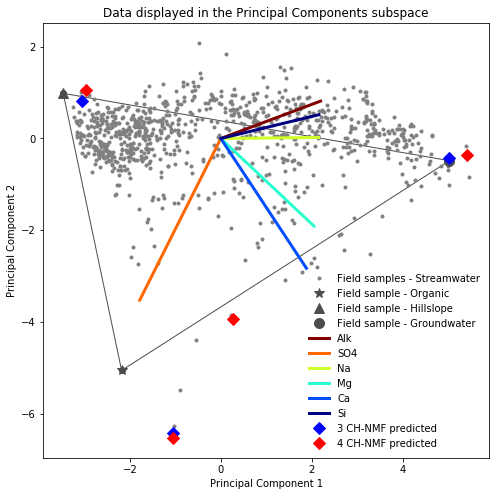

In [11]:
# Perform PCA EMMA, and make a base plot in the PC subspace
[X,P,mean,std] = do_PCAEMMA(data, end_members)
# Perform CH-NMF for 3 and 4 end-member cases, and plot them onto the PC space
[proj3,rec3] = do_CHEMMA(data,P,num_of_bases = 3)
[proj4,rec4] = do_CHEMMA(data,P,num_of_bases = 4)
plt.plot(proj3[:, 0], proj3[:, 1], "bD", markersize=8,label = "3 CH-NMF predicted")
plt.plot(proj4[:, 0], proj4[:, 1], "rD", markersize=8, label = "4 CH-NMF predicted")
plt.legend(frameon=False, loc='lower right', numpoints=1, fontsize=10)

The following code shows how to perform COP-MEANS clustering for 100 four end-member CH-NMF runs.

In [12]:
# Do 100 CH-NMF runs
store4 = []
rec4 = []
for i in range(100):
     [proj4,rec] = do_CHEMMA(data, P, num_of_bases=4)
     store4.append(proj4)
     rec4.append(rec)
# reshape the end-members in PC and obs space so that they can be used in COP-KMEANS later        
input_matrix = np.array(store4).transpose(2,0,1).reshape(6,-1).T
obs_matrix = np.array(rec4).transpose(2,0,1).reshape(6,-1).T
a = []
b = []
c = []
d = []
for i in range(100):
    a.append(4 * i)
    b.append(4 * i + 1)
    c.append(4 * i + 2)
    d.append(4 * i + 3)
# Specify constraints for COP-KMEANS
must_link = []
cannot_link = zip(a, b) + zip(b, c) + zip(c, d) + zip(a, c) + zip(a, d)  + zip(b, d)
# Run COP-KMEANS
clusters, centers = cop_kmeans(dataset=input_matrix, k=4, ml=must_link,cl=cannot_link)
# Color coded the clusters
color = np.array([str(i) for i in clusters])
color[color == '0'] = 'r'
color[color == '1'] = 'b'
color[color == '2'] = 'g'
color[color == '3'] = 'c'
# Uncomment the following section if want to have the run recorded
# np.savetxt('4EM.csv', input_matrix, delimiter=',')
# np.savetxt('4EM_cluster.csv', clusters, delimiter=',')
# np.savetxt('4EM_centers.csv', centers, delimiter=',')

Make plots like Figure 3 b and d.

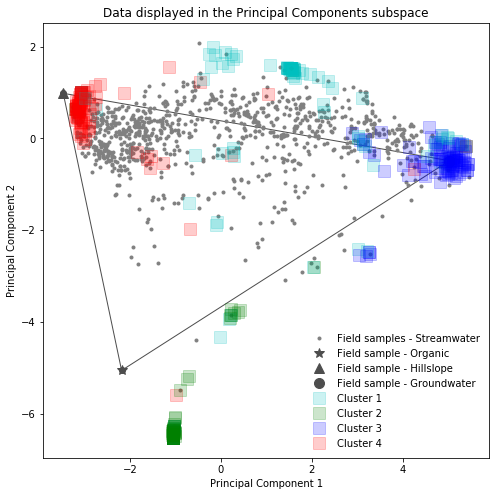

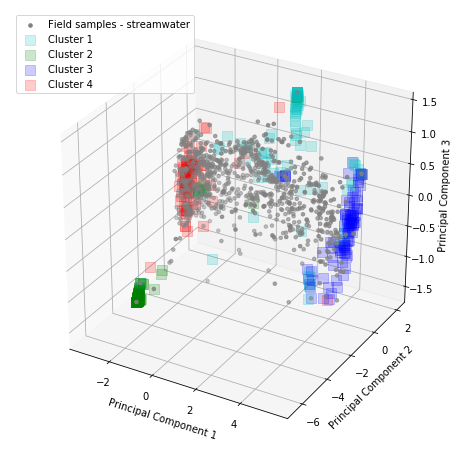

In [18]:
# Make the plot
# 2-D projection
twoD_obs_proj(X,P, end_members)
for i in range(len(color)-4):
    plt.plot(input_matrix[i, 0], input_matrix[i, 1], color[i] + 's', markersize=12, alpha = 0.2)
for i in range(len(color)-4,len(color)):
    plt.plot(input_matrix[i, 0], input_matrix[i, 1],  color[i] + 's', markersize=12, alpha = 0.2, label='Cluster {}'.format(i - len(color) + 5))
plt.legend(frameon=False, loc='lower right', numpoints=1, fontsize=10)

# 3-D projection
fig = plt.figure()
ax = plt.axes(projection='3d')
Y = np.dot(X, P.T)
ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], s=50, marker='.', color='0.5', label='Field samples - streamwater')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
# ax.scatter3D(proj4[:, 0], proj4[:, 1], proj4[:, 2], s = 100, marker = "*", color = 'blue', label='EMs')
for i in range(len(color)-4):
    ax.scatter3D(input_matrix[i, 0], input_matrix[i, 1], input_matrix[i, 2], s=100, marker="s", color=color[i], alpha = 0.2)
for i in range(len(color)-4,len(color)):
    ax.scatter3D(input_matrix[i, 0], input_matrix[i, 1], input_matrix[i, 2], s=100, marker="s", color=color[i], label='Cluster {}'.format(i - len(color) + 5),alpha = 0.2)
plt.legend(loc='upper left', numpoints=1, fontsize=10)


The following section calculates the means and standard deviation (st.dev) for the six measured solutes within clusters. 

In [ ]:
[meana,vara] = [np.mean(input_matrix[color == "r"],axis = 0), np.std(input_matrix[color == "r"],axis = 0)]
[meanb,varb] = [np.mean(input_matrix[color == "b"],axis = 0), np.std(input_matrix[color == "b"],axis = 0)]
[meanc,varc] = [np.mean(input_matrix[color == "g"],axis = 0), np.std(input_matrix[color == "g"],axis = 0)]
[meand,vard] = [np.mean(input_matrix[color == "c"],axis = 0), np.std(input_matrix[color == "c"],axis = 0)]
mea = np.vstack((meana,meanb,meanc,meand))
var = np.vstack((vara,varb,varc,vard))
print "In PC space, the means are: {} and the st.dev are: {}".format(mea, var)
# Uncomment the following section if want to have the stats recorded
# np.savetxt('4EM_PC_mean.csv', mea, delimiter=',')
# np.savetxt('4EM_PC_var.csv', var, delimiter=',')
[meana,vara] = [np.mean(obs_matrix[color == "r"],axis = 0), np.std(obs_matrix[color == "r"],axis = 0)]
[meanb,varb] = [np.mean(obs_matrix[color == "b"],axis = 0), np.std(obs_matrix[color == "b"],axis = 0)]
[meanc,varc] = [np.mean(obs_matrix[color == "g"],axis = 0), np.std(obs_matrix[color == "g"],axis = 0)]
[meand,vard] = [np.mean(obs_matrix[color == "c"],axis = 0), np.std(obs_matrix[color == "c"],axis = 0)]
mea = np.vstack((meana,meanb,meanc,meand))
var = np.vstack((vara,varb,varc,vard))
print "In obervational space, the means are: {} and the st.dev are: {}".format(mea, var)
# Uncomment the following section if want to have the stats recorded
# np.savetxt('4EM_PC_mean.csv', mea, delimiter=',')
# np.savetxt('4EM_PC_var.csv', var, delimiter=',')
